<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Используемые-материалы" data-toc-modified-id="Используемые-материалы-1">Используемые материалы</a></span></li><li><span><a href="#MNIST" data-toc-modified-id="MNIST-2">MNIST</a></span></li><li><span><a href="#First-step-:-classify-any-image-as-a-3-or-a-7" data-toc-modified-id="First-step-:-classify-any-image-as-a-3-or-a-7-3">First step : classify any image as a 3 or a 7</a></span></li><li><span><a href="#First-Try:-Pixel-Similarity" data-toc-modified-id="First-Try:-Pixel-Similarity-4">First Try: Pixel Similarity</a></span><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-4.1">Baseline</a></span></li><li><span><a href="#Baseline-:-average-пикселей" data-toc-modified-id="Baseline-:-average-пикселей-4.2">Baseline : average пикселей</a></span></li><li><span><a href="#NumPy-Arrays-and-PyTorch-Tensors" data-toc-modified-id="NumPy-Arrays-and-PyTorch-Tensors-4.3">NumPy Arrays and PyTorch Tensors</a></span></li><li><span><a href="#Computing-Metrics-Using-Broadcasting" data-toc-modified-id="Computing-Metrics-Using-Broadcasting-4.4">Computing Metrics Using Broadcasting</a></span></li></ul></li></ul></div>

## Используемые материалы

https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb

## MNIST

We will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.  

## First step : classify any image as a 3 or a 7

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [6]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [11]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [40]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

Here we are using the **Image** class from the **Python Imaging Library (PIL)**, which is the most widely used Python package for opening, manipulating, and viewing images. **Jupyter** knows about PIL images, so it **displays** the image for us **automatically**.

Converted to a NumPy array:

In [14]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

The 4:10 indicates we requested the rows from index 4 (included) to 10 (not included) and the same for the columns.

Here's the same thing as a PyTorch tensor:

In [16]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [19]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [20]:
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels. 

## First Try: Pixel Similarity

### Baseline

* Модель простая в разработке и проверке
* Есть уверенность, что она должна работать достаточно хорошо
* Будем сравнивать наши изощренные модели с Baseline-решением

### Baseline : average пикселей

In [25]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

<AxesSubplot:>

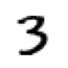

In [38]:
show_image(three_tensors[1], cmap="binary")

Далее:
* combine all the images in this list into a single three-dimensional tensor
* the pixel values are expected to be between 0 and 1, so we will also divide by 255

In [28]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

 As far as **PyTorch is concerned**, it is just a bunch of **numbers in memory**.

The length of a tensor's shape is its **rank**:

In [32]:
len(stacked_threes.shape)

3

Закрепим терминологию:
* **rank** is the number of axes or dimensions in a tensor
* **shape** is the size of each axis of a tensor.

We can also get a tensor's rank directly with **ndim**:

In [30]:
stacked_threes.ndim

3

We calculate the **mean** of all the image tensors by taking the mean along dimension **0** of our stacked, rank-3 tensor.

In other words, **for every pixel position**, this will **compute the average** of that pixel over all images. The **result** will be **one value** for every pixel position, or a **single image**. Here it is:

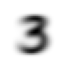

In [37]:
mean3 = stacked_threes.mean(0)
show_image(mean3, cmap="binary");

According to this dataset, this is the **ideal** number 3!

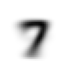

In [36]:
mean7 = stacked_sevens.mean(0)
show_image(mean7, cmap="binary");

Here's a sample 3:

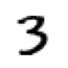

In [41]:
a_3 = stacked_threes[1]
show_image(a_3, cmap="binary");

How can we determine its **distance from** our **ideal** 3?

Требование: растояние должно быть неотрицательным, иначе + и - могут компенсировать друг друга.

To avoid this, there are **two main ways** data scientists **measure distance** in this context:
* Take the **mean of the absolute value** of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or **L1 norm**
* Take the **mean of the square of differences** (which makes everything positive) **and then take the square root** (which undoes the squaring). This is called the **root mean squared error (RMSE) or L2 norm**.

Посчитаем оба:

In [42]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [43]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between **our 3** and the **"ideal" 3** is **less** than the distance to the **ideal 7**. So our simple model will give the right prediction in this case.

В PyTorch уже встроены эти вычисления:

In [44]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Here **mse** stands for *mean squared error*, and **l1** refers to the standard mathematical jargon for *mean absolute value* (in math it's called the **L1 norm**).

Интуитивно понятно, что разница между **mse** и **l1** в том, что **mse** больше наказывает за большие отклонения 

### NumPy Arrays and PyTorch Tensors

Разница:
* API **NumPy Arrays** and **PyTorch Tensors** очень похожи.  
* Но NumPy не позволяет использовать GPU для вычисления градиента 
* Поэтому в курсе чаще используется PyTorch Tensors

Скорость:
* NumPy и PyTorch быстро работают за счет того, что они обертки на C-программами
* **NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python**
* A NumPy array is a multidimensional table of data, with all items of the same type. If the items are all of some simple type such as **integer** or **float**, then NumPy will store them as a **compact** C data structure in memory.
* PyTorch даже более строгий чем NumPy и обладает большими возможностями

Создание:

In [46]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [47]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [48]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [49]:
tns[1]

tensor([4, 5, 6])

In [55]:
tns[1,1:3]

tensor([5, 6])

In [56]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [57]:
tns.type()

'torch.LongTensor'

In [58]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

### Computing Metrics Using Broadcasting

Проверим нашу модель:

In [60]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Simple function that calculates the mean absolute error:

In [61]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

* Мы получили расстояние между двумя картинками
* Но нам нужно пройти по всем 1010 картинкам и для каждой посчитать расстояние
* Но делать так мы конечно не будем, а вместо этого жахнем тензоны в нашу функцию

In [62]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

Но размерности не совпадали!!! Почему это сработало?

Ответ в вычислении **(a-b)**:
* Когда Pytorch выполняет вычитание между тензорами разных рангов используется **broadcasting**
* А именно: тензор меньшего ранга автоматически расширяется до большего  

В результате мы пишем меньше кода

Еще один пример broadcasting-а:

In [63]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

В нашем случае можем посмотреть что ранг действительно расширился (mean3 как будто размножил себя 1010 раз перед вычитанием):

In [64]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

Но в действительности дополнительных аллокаций памяти для тиражирования mean3 1010 раз внутри Pytorch не происходило!

Далее, **abs** применялся к каждому элементу тензора

**mean((-1,-2)** означает применение mean к последней и предпоследней оси тензора, то есть к горизонтальной и вертикальной осям картики.  
In other words, for every image, we averaged the intensity of all the pixels in that image.

Составим функцию:

In [68]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

Пример использования:

In [70]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Full validation set of 3s:

In [72]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

Now we can calculate the **accuracy** for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s:

In [73]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

**Что в итоге?**

* 90% accuracy - хорошо для начала
* Но 3 и 7 слишком разные в написании цифры, есть еще и остальные